---


## 01.Original way
- dataset: sampling method (uniform random over [-1, 1])
- dataset size:
    - training set: 256
    - validation set: 256
    - test set: 1000
- Neurak network architecture:
    - hidden layers: 2
    - nonlinear function: tanh
    - tanh units: 64
- optimizer: Adam
- learning rate: $2e-3$
- weight decay: $1e-5$
- epoches: 800
- Loss metric: MSE

In [2]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt




In [3]:
seed = 42
n_train, n_val, n_test = 256, 256, 1000
hidden = 64
lr = 2e-3
weight_decay = 1e-5
epochs = 800
patience = 80
device = "cpu"



In [4]:
torch.manual_seed(seed)
np.random.seed(seed)

def f(x):
    return 1.0 / (1.0 + 25.0 * x**2)

def fprime(x):
    # f'(x) = -50 x / (1 + 25 x^2)^2
    return -50.0 * x / (1.0 + 25.0 * x**2)**2

# Dataset ->>> uniform
x_train = np.random.uniform(-1.0, 1.0, (n_train, 1))
x_val   = np.random.uniform(-1.0, 1.0, (n_val, 1))
x_test  = np.linspace(-1.0, 1.0, n_test).reshape(-1, 1)
y_train, y_val, y_test = f(x_train), f(x_val), f(x_test)

toT = lambda a: torch.from_numpy(a).float().to(device)
Xtr, Ytr = toT(x_train), toT(y_train)
Xva, Yva = toT(x_val),   toT(y_val)
Xte, Yte = toT(x_test),  toT(y_test)

train_dl = DataLoader(TensorDataset(Xtr, Ytr), batch_size=64, shuffle=True)


In [5]:
class MLP(nn.Module):
    def __init__(self, h=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, h), nn.Tanh(),
            nn.Linear(h, h), nn.Tanh(),
            nn.Linear(h, 1)
        )
    def forward(self, x): return self.net(x)

model = MLP(hidden).to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.MSELoss()



In [7]:
train_losses, val_losses = [], []
best_val = float("inf"); best_state = None; since_best = 0

for ep in range(1, epochs+1):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb); loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()

    model.eval()
    with torch.no_grad():
        tr = loss_fn(model(Xtr), Ytr).item()
        va = loss_fn(model(Xva), Yva).item()
    train_losses.append(tr); val_losses.append(va)

    if va < best_val - 1e-7:
        best_val = va
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        since_best = 0
    else:
        since_best += 1
        if since_best >= patience:
            break

if best_state is not None:
    model.load_state_dict(best_state)

model.eval()
with torch.no_grad():
    y_pred = model(Xte).cpu().numpy()

mse = float(np.mean((y_pred - y_test)**2))
max_err = float(np.max(np.abs(y_pred - y_test)))
print(f"Test MSE      : {mse:.6e}")
print(f"Test Max |err|: {max_err:.6e}")



Test MSE      : 2.116125e-06
Test Max |err|: 5.306233e-03


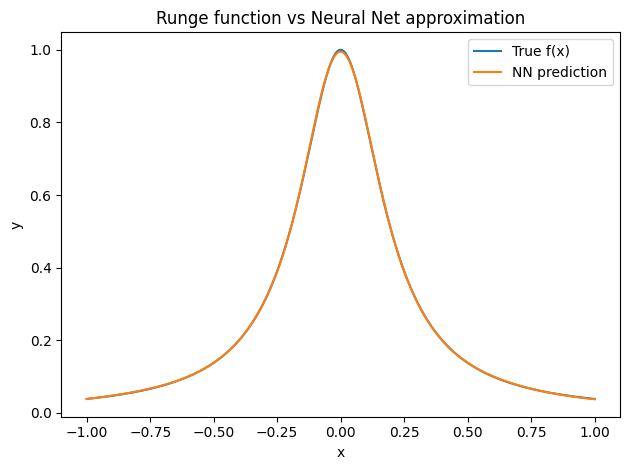

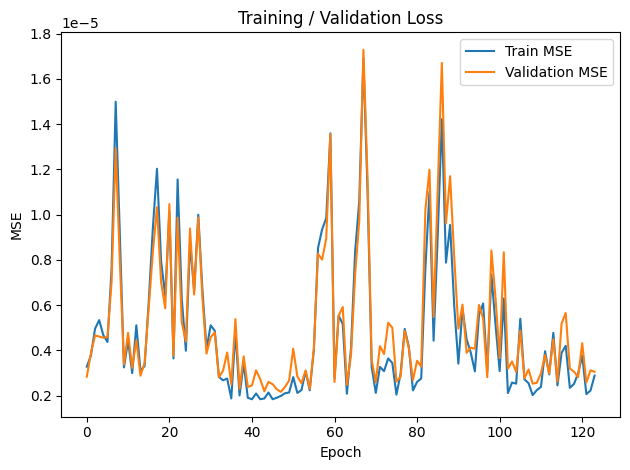

In [8]:
# ---------- plots ----------
# 1) f(x) vs prediction
plt.figure()
plt.plot(x_test.ravel(), y_test.ravel(), label="True f(x)")
plt.plot(x_test.ravel(), y_pred.ravel(), label="NN prediction")
plt.title("Runge function vs Neural Net approximation")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.tight_layout()
plt.show()

# 2) loss curves
plt.figure()
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Validation MSE")
plt.title("Training / Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout()
plt.show()


### 01.1 Evaluate derivative

In [9]:
x_test_np = np.linspace(-1.0, 1.0, 1000).reshape(-1, 1)
x_test = torch.tensor(x_test_np, dtype=torch.float32, requires_grad=True)

model.eval()

# model output
yhat = model(x_test)                # shape [N,1]
ones = torch.ones_like(yhat)

#>_------------ dy/dx
dy_dx = torch.autograd.grad(
    outputs=yhat,
    inputs=x_test,
    grad_outputs=ones,
    create_graph=False,
    retain_graph=False,
    only_inputs=True
)[0]                                 # shape [N,1]

#  into numpy
yhat_prime = dy_dx.detach().cpu().numpy()
y_true_prime = fprime(x_test_np)

# MSE/ MAXErr
mse_deriv = float(np.mean((yhat_prime - y_true_prime)**2))
maxerr_deriv = float(np.max(np.abs(yhat_prime - y_true_prime)))

print(f"Derivative Test MSE     : {mse_deriv:.6e}")
print(f"Derivative Test Max|err|: {maxerr_deriv:.6e}")



Derivative Test MSE     : 1.390236e-03
Derivative Test Max|err|: 1.585899e-01


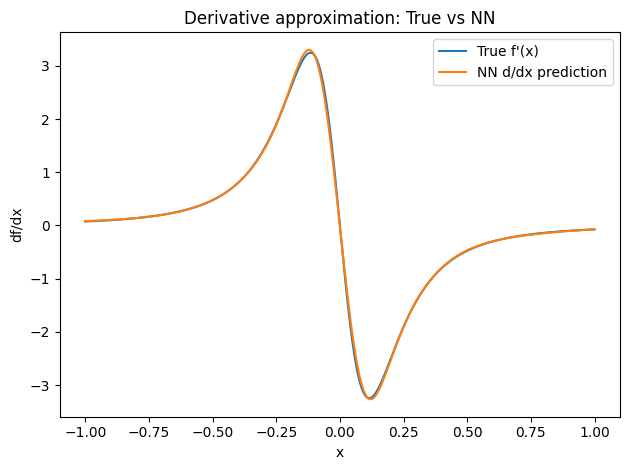

In [10]:
# Plot
plt.figure()
plt.plot(x_test_np.ravel(), y_true_prime.ravel(), label="True f'(x)")
plt.plot(x_test_np.ravel(), yhat_prime.ravel(),  label="NN d/dx prediction")
plt.title("Derivative approximation: True vs NN")
plt.xlabel("x"); plt.ylabel("df/dx"); plt.legend(); plt.tight_layout()
plt.show()

## 02. Using Chebyshev nodes

## Original way
- dataset: sampling method (Chebyshev nodes over [-1, 1])
- dataset size:
    - training set: 256
    - validation set: 256
    - test set: 1000
- Neurak network architecture:
    - hidden layers: 2
    - tanh units: 64
- optimizer: Adam
- learning rate: $2e-3$
- weight decay: $1e-5$
- epoches: 800
- Loss metric: MSE

In [17]:
def chebyshev_nodes(n):
    k = np.arange(1, n+1)
    return np.cos((2*k - 1) / (2*n) * np.pi).reshape(-1,1)

x_train = chebyshev_nodes(n_train)
y_train = f(x_train)

x_val   = chebyshev_nodes(n_val)
y_val   = f(x_val)
x_test  = np.linspace(-1.0, 1.0, n_test).reshape(-1, 1)
y_test = f(x_test)

toT = lambda a: torch.from_numpy(a).float().to(device)
Xtr, Ytr = toT(x_train), toT(y_train)
Xva, Yva = toT(x_val),   toT(y_val)
Xte, Yte = toT(x_test),  toT(y_test)

train_dl = DataLoader(TensorDataset(Xtr, Ytr), batch_size=64, shuffle=True)



In [18]:
class MLP(nn.Module):
    def __init__(self, h=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, h), nn.Tanh(),
            nn.Linear(h, h), nn.Tanh(),
            nn.Linear(h, 1)
        )
    def forward(self, x): return self.net(x)

model = MLP(hidden).to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.MSELoss()

# ---------- train with early stopping ----------
train_losses, val_losses = [], []
best_val = float("inf"); best_state = None; since_best = 0

for ep in range(1, epochs+1):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb); loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()

    model.eval()
    with torch.no_grad():
        tr = loss_fn(model(Xtr), Ytr).item()
        va = loss_fn(model(Xva), Yva).item()
    train_losses.append(tr); val_losses.append(va)

    if va < best_val - 1e-7:
        best_val = va
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        since_best = 0
    else:
        since_best += 1
        if since_best >= patience:
            break

if best_state is not None:
    model.load_state_dict(best_state)

# ---------- evaluate ----------
model.eval()
with torch.no_grad():
    y_pred = model(Xte).cpu().numpy()

mse = float(np.mean((y_pred - y_test)**2))
max_err = float(np.max(np.abs(y_pred - y_test)))
print(f"Test MSE      : {mse:.6e}")
print(f"Test Max |err|: {max_err:.6e}")



Test MSE      : 6.710541e-06
Test Max |err|: 9.091664e-03


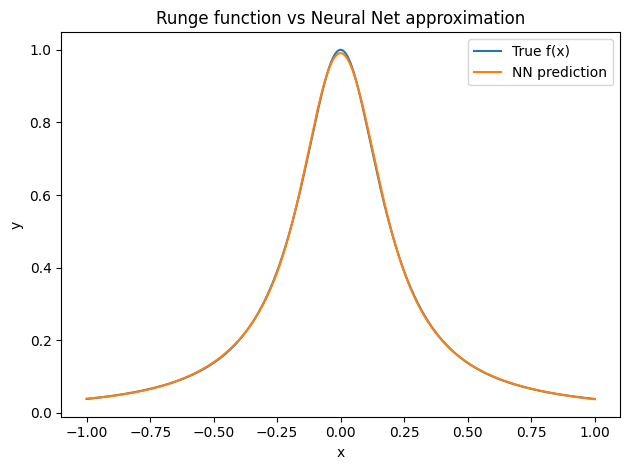

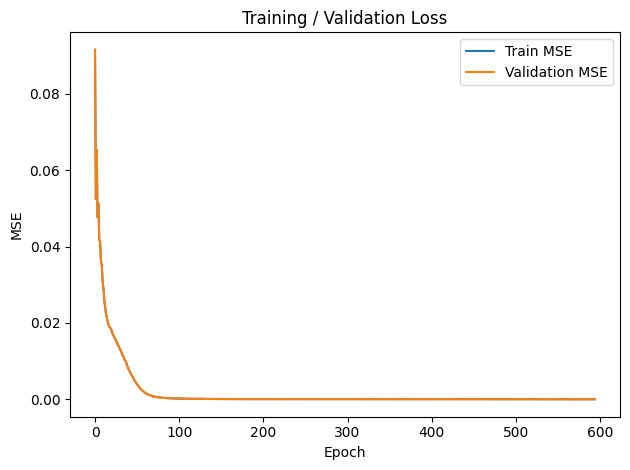

In [19]:
# ---------- plots ----------
# 1) f(x) vs prediction
plt.figure()
plt.plot(x_test.ravel(), y_test.ravel(), label="True f(x)")
plt.plot(x_test.ravel(), y_pred.ravel(), label="NN prediction")
plt.title("Runge function vs Neural Net approximation")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.tight_layout()
plt.show()

# 2) loss curves
plt.figure()
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Validation MSE")
plt.title("Training / Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout()
plt.show()


Derivative Test MSE     : 3.625471e-03
Derivative Test Max|err|: 2.243129e-01


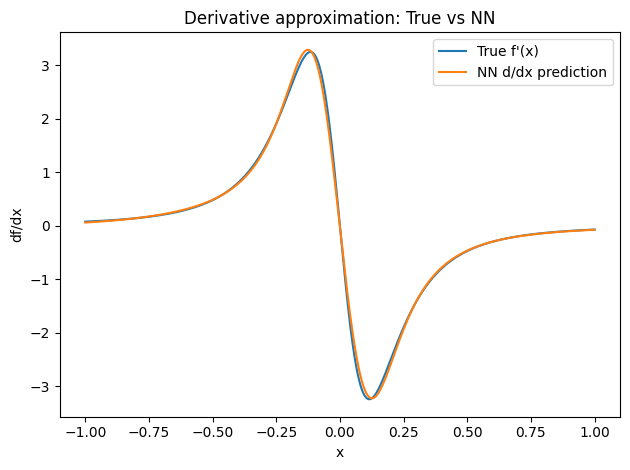

In [20]:
# make x_test into tensor 
x_test_np = np.linspace(-1.0, 1.0, 1000).reshape(-1, 1)
x_test = torch.tensor(x_test_np, dtype=torch.float32, requires_grad=True)

model.eval()

# 1) model output
yhat = model(x_test)                # shape [N,1]
ones = torch.ones_like(yhat)

# 2) dy/dx
dy_dx = torch.autograd.grad(
    outputs=yhat,
    inputs=x_test,
    grad_outputs=ones,
    create_graph=False,
    retain_graph=False,
    only_inputs=True
)[0]                                 # shape [N,1]

# 3) into numpy
yhat_prime = dy_dx.detach().cpu().numpy()
y_true_prime = fprime(x_test_np)

# 4) MSE/ MAXErr
mse_deriv = float(np.mean((yhat_prime - y_true_prime)**2))
maxerr_deriv = float(np.max(np.abs(yhat_prime - y_true_prime)))

print(f"Derivative Test MSE     : {mse_deriv:.6e}")
print(f"Derivative Test Max|err|: {maxerr_deriv:.6e}")

# 5) Plot
plt.figure()
plt.plot(x_test_np.ravel(), y_true_prime.ravel(), label="True f'(x)")
plt.plot(x_test_np.ravel(), yhat_prime.ravel(),  label="NN d/dx prediction")
plt.title("Derivative approximation: True vs NN")
plt.xlabel("x"); plt.ylabel("df/dx"); plt.legend(); plt.tight_layout()
plt.show()

## 03. Nonlinear function chaning: tanh -> ReLu
In the class MLP block

In [21]:
def chebyshev_nodes(n):
    k = np.arange(1, n+1)
    return np.cos((2*k - 1) / (2*n) * np.pi).reshape(-1,1)

x_train = chebyshev_nodes(n_train)
y_train = f(x_train)

x_val   = chebyshev_nodes(n_val)
y_val   = f(x_val)
x_test  = np.linspace(-1.0, 1.0, n_test).reshape(-1, 1)
y_test = f(x_test)

toT = lambda a: torch.from_numpy(a).float().to(device)
Xtr, Ytr = toT(x_train), toT(y_train)
Xva, Yva = toT(x_val),   toT(y_val)
Xte, Yte = toT(x_test),  toT(y_test)

train_dl = DataLoader(TensorDataset(Xtr, Ytr), batch_size=64, shuffle=True)



Test MSE      : 1.296343e-06
Test Max |err|: 4.976785e-03


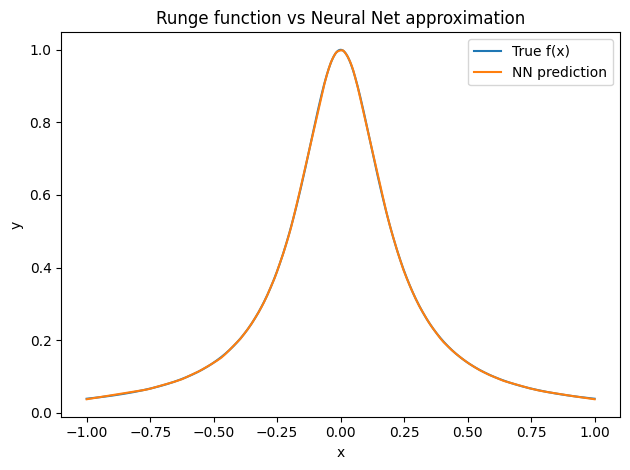

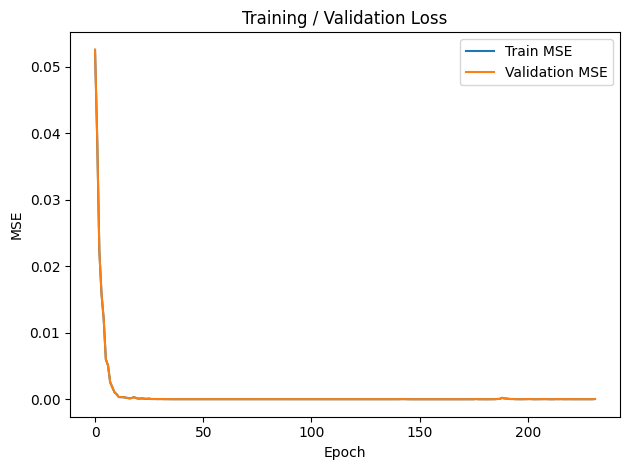

In [22]:
class MLP(nn.Module):
    def __init__(self, h=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, h), nn.ReLU(),
            nn.Linear(h, h), nn.ReLU(),
            nn.Linear(h, h), nn.ReLU(),
            nn.Linear(h, h), nn.ReLU(),
            nn.Linear(h, 1)
        )
    def forward(self, x): return self.net(x)

model = MLP(hidden).to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.MSELoss()

# ---------- train with early stopping ----------
train_losses, val_losses = [], []
best_val = float("inf"); best_state = None; since_best = 0

for ep in range(1, epochs+1):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb); loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()

    model.eval()
    with torch.no_grad():
        tr = loss_fn(model(Xtr), Ytr).item()
        va = loss_fn(model(Xva), Yva).item()
    train_losses.append(tr); val_losses.append(va)

    if va < best_val - 1e-7:
        best_val = va
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        since_best = 0
    else:
        since_best += 1
        if since_best >= patience:
            break

if best_state is not None:
    model.load_state_dict(best_state)

# ---------- evaluate ----------
model.eval()
with torch.no_grad():
    y_pred = model(Xte).cpu().numpy()

mse = float(np.mean((y_pred - y_test)**2))
max_err = float(np.max(np.abs(y_pred - y_test)))
print(f"Test MSE      : {mse:.6e}")
print(f"Test Max |err|: {max_err:.6e}")

# ---------- plots ----------
# 1) f(x) vs prediction
plt.figure()
plt.plot(x_test.ravel(), y_test.ravel(), label="True f(x)")
plt.plot(x_test.ravel(), y_pred.ravel(), label="NN prediction")
plt.title("Runge function vs Neural Net approximation")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.tight_layout()
plt.show()

# 2) loss curves
plt.figure()
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Validation MSE")
plt.title("Training / Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout()
plt.show()


Derivative Test MSE     : 3.625471e-03
Derivative Test Max|err|: 2.243129e-01


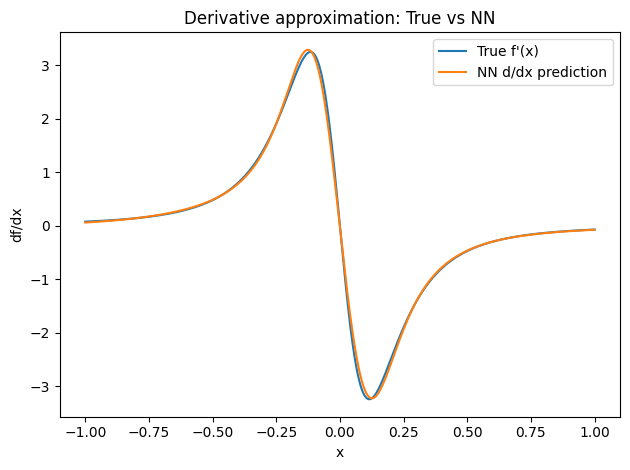

In [23]:
# make x_test into tensor 
x_test_np = np.linspace(-1.0, 1.0, 1000).reshape(-1, 1)
x_test = torch.tensor(x_test_np, dtype=torch.float32, requires_grad=True)

model.eval()

yhat_prime = dy_dx.detach().cpu().numpy()
y_true_prime = fprime(x_test_np)

# 4) MSE/ MAXErr
mse_deriv = float(np.mean((yhat_prime - y_true_prime)**2))
maxerr_deriv = float(np.max(np.abs(yhat_prime - y_true_prime)))

print(f"Derivative Test MSE     : {mse_deriv:.6e}")
print(f"Derivative Test Max|err|: {maxerr_deriv:.6e}")

# 5) Plot
plt.figure()
plt.plot(x_test_np.ravel(), y_true_prime.ravel(), label="True f'(x)")
plt.plot(x_test_np.ravel(), yhat_prime.ravel(),  label="NN d/dx prediction")
plt.title("Derivative approximation: True vs NN")
plt.xlabel("x"); plt.ylabel("df/dx"); plt.legend(); plt.tight_layout()
plt.show()

所以把activation function從$\tanh(x)$改成ReLu的時候導數會錯蠻多的?!

---

## 04. 測試其他的 Target Fuction 看有沒有效
$$f(x)=\frac{1}{x^2}$$
這個函數在$x=0$的時候不連續所以用上面的方法會爆炸

In [24]:
def chebyshev_nodes(n):
    k = np.arange(1, n+1)
    return np.cos((2*k - 1) / (2*n) * np.pi).reshape(-1,1)

x_train = chebyshev_nodes(n_train)
y_train = f(x_train)

x_val   = chebyshev_nodes(n_val)
y_val   = f(x_val)
x_test  = np.linspace(-1.0, 1.0, n_test).reshape(-1, 1)
y_test = f(x_test)

toT = lambda a: torch.from_numpy(a).float().to(device)
Xtr, Ytr = toT(x_train), toT(y_train)
Xva, Yva = toT(x_val),   toT(y_val)
Xte, Yte = toT(x_test),  toT(y_test)

train_dl = DataLoader(TensorDataset(Xtr, Ytr), batch_size=64, shuffle=True)



In [25]:
class MLP(nn.Module):
    def __init__(self, h=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, h), nn.ReLU(),
            nn.Linear(h, h), nn.ReLU(),
            nn.Linear(h, h), nn.ReLU(),
            nn.Linear(h, h), nn.ReLU(),
            nn.Linear(h, 1)
        )
    def forward(self, x): return self.net(x)

model = MLP(hidden).to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.MSELoss()



Test MSE      : 7.863833e-07
Test Max |err|: 4.702011e-03


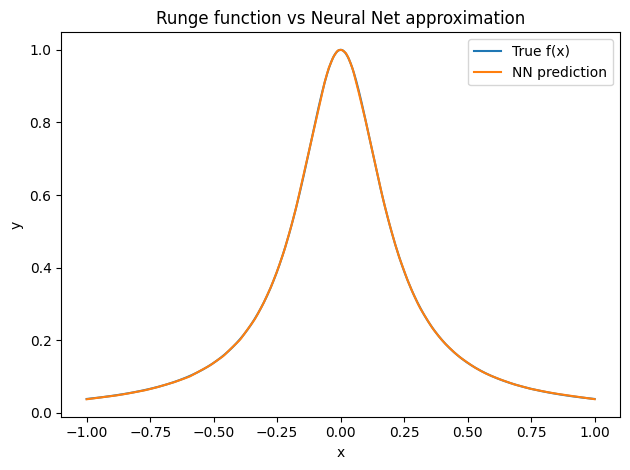

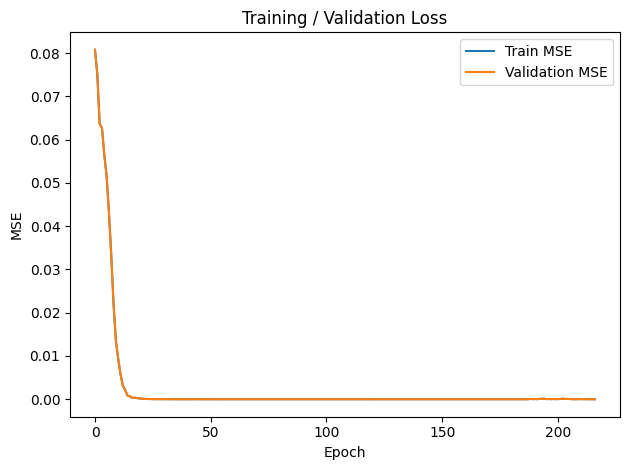

In [26]:
# ---------- train with early stopping ----------
train_losses, val_losses = [], []
best_val = float("inf"); best_state = None; since_best = 0

for ep in range(1, epochs+1):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb); loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()

    model.eval()
    with torch.no_grad():
        tr = loss_fn(model(Xtr), Ytr).item()
        va = loss_fn(model(Xva), Yva).item()
    train_losses.append(tr); val_losses.append(va)

    if va < best_val - 1e-7:
        best_val = va
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        since_best = 0
    else:
        since_best += 1
        if since_best >= patience:
            break

if best_state is not None:
    model.load_state_dict(best_state)

# ---------- evaluate ----------
model.eval()
with torch.no_grad():
    y_pred = model(Xte).cpu().numpy()

mse = float(np.mean((y_pred - y_test)**2))
max_err = float(np.max(np.abs(y_pred - y_test)))
print(f"Test MSE      : {mse:.6e}")
print(f"Test Max |err|: {max_err:.6e}")

# ---------- plots ----------
# 1) f(x) vs prediction
plt.figure()
plt.plot(x_test.ravel(), y_test.ravel(), label="True f(x)")
plt.plot(x_test.ravel(), y_pred.ravel(), label="NN prediction")
plt.title("Runge function vs Neural Net approximation")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.tight_layout()
plt.show()

# 2) loss curves
plt.figure()
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Validation MSE")
plt.title("Training / Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout()
plt.show()


Derivative Test MSE     : 3.625471e-03
Derivative Test Max|err|: 2.243129e-01


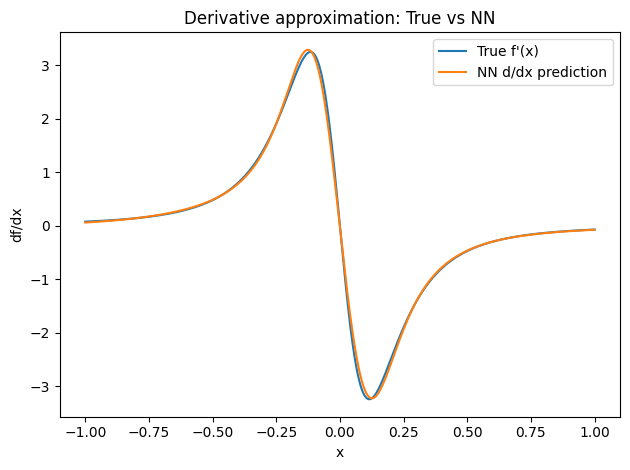

In [27]:
x_test_np = np.linspace(-1.0, 1.0, 1000).reshape(-1, 1)
x_test = torch.tensor(x_test_np, dtype=torch.float32, requires_grad=True)

model.eval()

yhat = model(x_test)                # shape [N,1]
ones = torch.ones_like(yhat)

yhat_prime = dy_dx.detach().cpu().numpy()
y_true_prime = fprime(x_test_np)

mse_deriv = float(np.mean((yhat_prime - y_true_prime)**2))
maxerr_deriv = float(np.max(np.abs(yhat_prime - y_true_prime)))

print(f"Derivative Test MSE     : {mse_deriv:.6e}")
print(f"Derivative Test Max|err|: {maxerr_deriv:.6e}")

# 5) Plot
plt.figure()
plt.plot(x_test_np.ravel(), y_true_prime.ravel(), label="True f'(x)")
plt.plot(x_test_np.ravel(), yhat_prime.ravel(),  label="NN d/dx prediction")
plt.title("Derivative approximation: True vs NN")
plt.xlabel("x"); plt.ylabel("df/dx"); plt.legend(); plt.tight_layout()
plt.show()